In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [445]:
#Step 1

# get data file names and keep valid files 
#i.e. not empty or without zero and negative price
# data are saved on a list in the form of (stock name, dataframe)

path =r'archive\Stocks'
filenames = glob.glob(path + "/*.txt")
valid_dfs = []
performances = []
corrected_stocks = []

for filename in filenames:  
    try:
        stock = filename.split('\\')[-1].split('.')[0]
        df = pd.read_csv(filename, index_col=None, header=0)
        #Keep files with non zero and negative prices
        if min(df.Low)>0 and min(df.High)>0 and min(df.Open)>0 and min(df.Close)>0:
            df['stock'] = stock
            df['Date']= pd.to_datetime(df['Date'])
            df.set_index('Date',inplace=True)
            
            #delete zero volume days
            df = df[df.Volume!=0]
            
            #Delete problematic rows with small Low value
            check1 = (df.sort_values(by='Low').Low[1]-df.sort_values\
                      (by='Low').Low[0])/df.sort_values(by='Low').Low[0]
            if check1>10:
                df = df[df.Low!=min(df.Low)] #Delete problematic row
                corrected_stocks.append(stock)
             
            #Delete problematic rows with large High value
            check2 = (df.sort_values(by='High').High[-1]-df.sort_values\
                      (by='High').High[-2])/df.sort_values(by='High').High[-2]
            if check2>10:
                df = df[df.High!=max(df.High)] #Delete problematic row
                corrected_stocks.append(stock)

            #Find max and minimum price and corresponding date over the years
            max_price = max(df.High)
            min_price = min(df.Low)
            max_date = df[df.High==max_price].iloc[[-1]].index
            min_date = df[df.Low==min_price].iloc[[0]].index
            
            #Keep stocks that maximum overall price happened after minimum
            if max_date >  min_date:
                max_pct = (max_price-min_price)/min_price
                max_abs = (max_price-min_price)
                performances.append((stock,max_pct,max_abs))
                valid_dfs.append((stock,df))
            
    except:
        pass        

print('Out of',len(filenames),'txt files on the /Stocks directory,')
print('The non empty and non negative valued stocks are',len(valid_dfs))
print("The following stocks were corrected",corrected_stocks)


Out of 7195 txt files on the /Stocks directory
The non empty and non negative valued stocks are 4632
The following stocks were corrected ['ako-a', 'alt', 'bofil', 'cbmxw', 'civbp', 'cxdc', 'gcbc', 'loan', 'marps', 'myndw', 'newt', 'nspr-ws', 'nssc', 'ntwk', 'ofg_a', 'patk', 'phii', 'rox', 'slp', 'smbk', 'smed', 'strm', 'tgen']


In [446]:
#Rank overall performances of stocks
best_performances_df = pd.DataFrame(performances, columns=['stock','pct','abs']
                          ).sort_values(by=['pct'],ascending=False,ignore_index=True)

In [477]:
#Select 10 stocks for the small and 100 stocks for the big sequence
good_stock_names = best_performances_df[:100].stock.values 
print('The stocks we are going to analyze are',good_stock_names)

The stocks we are going to analyze are ['wmt' 'inpx' 'intc' 'hd' 'mo' 'aumn' 'amgn' 'biib' 'msft' 'uve' 'csco'
 'brk-a' 'twx' 'mcd' 'adbe' 'amzn' 'atro' 'ba' 'unh' 'aapl' 'gd' 'viav'
 'rost' 'ben' 'patk' 'hgsh' 'ed' 'utx' 'kr' 'gild' 'bby' 'amat' 'kins'
 'esrx' 'orcl' 'lmt' 'dis' 'luv' 'bwen' 'ensv' 'nke' 'jnj' 'jazz' 'ppc'
 'lrcx' 'mdt' 'silc' 'kgji' 'nvcn' 'exas' 'cl' 'aet' 'qcom' 'dhr' 'hpq'
 'rok' 'adsk' 'isdr' 'pir' 'schw' 'afl' 'dte' 'tjx' 'syk' 'iac' 'atsg'
 'sbux' 'vhc' 'rtrx' 'gv' 'cvx' 'car' 'low' 'bcr' 'hon' 'tree' 'axp'
 'snbr' 'payx' 'mrk' 'aaba' 'mxim' 'mchp' 'nxst' 'dan' 'nvda' 'bdx' 'mmm'
 'gntx' 'mgpi' 'trec' 'trow' 'expd' 'nflx' 'tcx' 'fast' 'bxp' 'wec' 'jbl'
 'fisv']


In [479]:
#Step 2

#Select some good trades (buy and sell dates) for each of the good stocks
#Also create the concatenation of dataframes of good stocks

good_moves_li = []
good_stocks_df_li = []

for (name,df) in valid_dfs:
    if name in good_stock_names:
        #Create dataframe with all good stocks to plot performance
        good_stocks_df_li.append(df)
        
        #Check the percentage change for multiple periods
        for period in range(1,len(df)//2,5):  
            df['change_high']=df.High.pct_change(periods=period)
            for sell_date in df.sort_values(by=['change_high'],ascending=False).iloc[0:5].index:
                
                idx = df.index.get_loc(sell_date)
                buy_date = df.iloc[idx-period].name
                low_price = df.iloc[idx-period].Low

                vol_buy_date = df.iloc[idx-period].Volume
                high_price = df.iloc[idx].High
                vol_sell_date = df.iloc[idx].Volume
            
                good_moves_li.append((name,buy_date,vol_buy_date,low_price,'buy'))
                good_moves_li.append((name,sell_date,vol_sell_date,high_price,'sell'))

In [480]:
#Concatenated dataframe of all used stocks to look up 
#closing prices on each day and calcuate portfolio value

good_stocks_df= pd.concat(good_stocks_df_li)

In [481]:
#Create dataframe of the good moves to iterate through and perform the buy and sell functions
good_moves = pd.DataFrame(good_moves_li,columns=['stock','date','volume','price','action'])

#Sort by date and always buy before sell on a given day
good_moves.sort_values(by=['date','action'],inplace=True) 

# Delete duplicates (buy or sell the same stock on the same day)
good_moves.drop_duplicates(inplace=True)  
good_moves = good_moves.drop_duplicates(subset=['stock', 'date'],keep='first') 

In [482]:
#Concatenated dataframe of used stocks
#Used to evaluate portfolio on each day
good_stocks_df

,Open,High,Low,Close,Volume,OpenInt,stock,change_high
Date,,,,,,,,
1996-04-12,1.05,1.79,1.02,1.38,408720000,0,aaba,NaN
1996-04-15,1.49,1.50,1.25,1.34,79231200,0,aaba,NaN
1996-04-16,1.34,1.34,1.17,1.20,48026400,0,aaba,NaN
1996-04-17,1.18,1.18,1.03,1.12,42871200,0,aaba,NaN
1996-04-18,1.25,1.25,1.17,1.22,27352800,0,aaba,NaN
...,...,...,...,...,...,...,...,...
2017-11-06,89.42,89.68,88.68,88.70,5255777,0,wmt,8.182879
2017-11-07,88.87,89.06,88.42,88.95,5346721,0,wmt,8.069246
2017-11-08,89.11,90.42,89.10,90.26,6766963,0,wmt,8.258652


In [483]:
#Search Space for buy and sell moves 
good_moves

,stock,date,volume,price,action
432658,mcd,1970-01-12,3046467,0.27521,buy
432652,mcd,1970-01-13,2941413,0.26712,buy
432646,mcd,1970-01-14,1245597,0.26712,buy
432648,mcd,1970-01-15,2311109,0.26712,buy
432640,mcd,1970-01-19,1590766,0.25916,buy
...,...,...,...,...,...
514779,nflx,2017-11-10,6620920,192.59000,sell
525721,nvda,2017-11-10,31300857,218.67000,sell
566895,rok,2017-11-10,541930,193.00000,sell
585277,sbux,2017-11-10,7930117,57.39000,sell


In [486]:
#Step 3
#Iterate through the good moves and buy and sell the stocks. 
#Also Keeping the values of cash balance and portfolio value of each day to plot

portfolio = {'cash':1}
transactions = []
time_values = []
i=0
for index,row in good_moves.iterrows():
    if row.action=='buy':
        buy_low(portfolio,transactions,row.stock,row.date,row.price,row.volume)
    else:
        sell_high(portfolio,transactions,row.stock,row.date,row.price,row.volume)

    #Get closing value of portfolio for certain dates
    #Getting it for all dates is very slow for the size of the dataframe
    if i%250==0:
        port_value = portfolio_closing_value(portfolio,str(row.date))
        time_values.append((row.date,portfolio['cash'],port_value))
    i+=1

print('Made',len(transactions),'transactions')
print('Made $m',round(portfolio['cash']/1000000,2))

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
20500
20750
21000
21250
21500
21750
22000
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000
25250
25500
25750
26000
26250
26500
26750
27000
27250
27500
27750
28000
28250
28500
28750
29000
29250
29500
29750
30000
30250
30500
30750
31000
31250
31500
31750
32000
32250
32500
32750
33000
33250
33500
33750
34000
34250
34500
34750
35000
35250
35500
35750
36000
36250
36500
36750
37000
37250
37500
37750
38000
38250
38500
38750
39000
39250
39500
39750
40000
40250
40500
40750
41000
41250
41500
41750
42000
42250
42500
42750
43000
43250
43

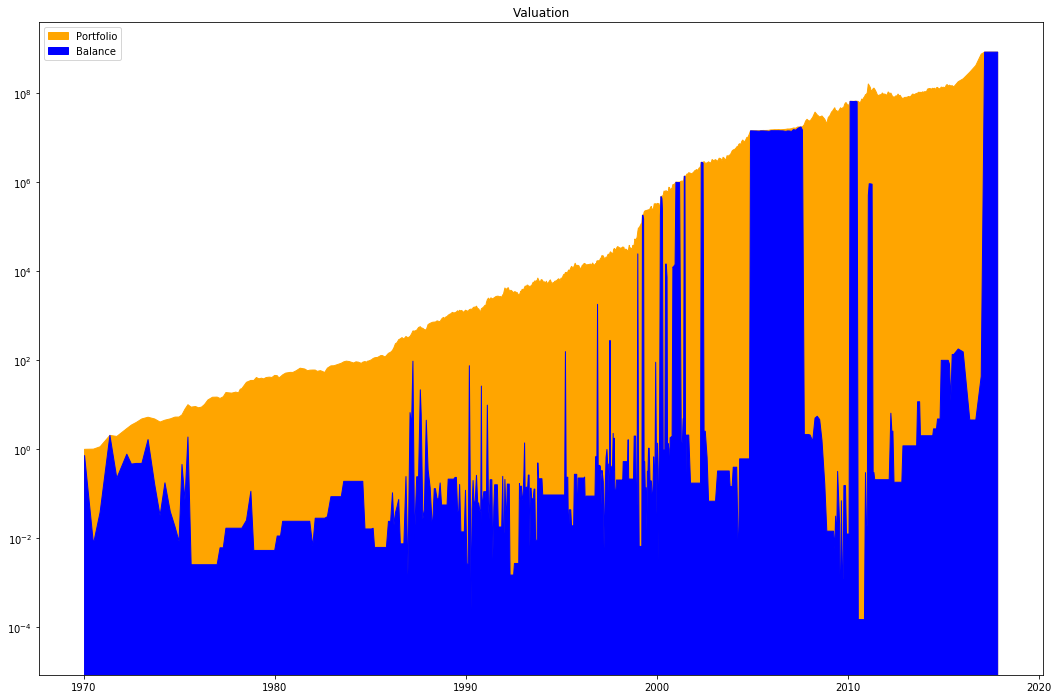

In [487]:
#Plot valuation diagram

time_series = pd.DataFrame(time_values,columns=['date','balance','portfolio'])
x = time_series.date
y = time_series.balance
z = time_series.portfolio
plt.rcParams["figure.figsize"] = (18,12)
plt.fill_between(x, z,label='Portfolio',color='orange')
plt.fill_between(x, y,label='Balance',color='b')
plt.legend(loc='upper left')
plt.title('Valuation')
plt.yscale('log')
plt.savefig('figs/plot_large')

In [38]:
#Functions used through the iteration

#'Buy Low' Function to update portfolio and append a transaction
def buy_low(portfolio,transactions,stock,date,price,vol):    
    if stock in portfolio.keys():
        num = min(portfolio[stock]+1,portfolio['cash']//price,vol//10)
        portfolio[stock]+=num
    else:
        num = min(1,portfolio['cash']//price,vol//10)
        portfolio[stock]=num
    if num>0:
        portfolio['cash']-=price*num
        transactions.append((date,'buy-low',stock,num))  

#'Sell High' Function to update portfolio and append a transaction      
def sell_high(portfolio,transactions,stock,date,price,vol):
    if stock in portfolio.keys():
        num = min(portfolio[stock],vol//10)
        portfolio[stock]-=num
        portfolio['cash']+=price*num
        if num>0:
            transactions.append((date,'sell-high',stock,num)) 
            
#Function to calculate the closing price of a portfolio on a given day       
def portfolio_closing_value(portfolio,date):
    value = portfolio['cash']
    for stock in portfolio.keys():
        if stock in good_stocks_df.loc[date].stock.values:
            stock_closing_price = good_stocks_df[good_stocks_df.stock==stock].loc[date].Close
            value += stock_closing_price*portfolio[stock]
    return value

In [488]:
#Function to write transactions to a txt file
def write_txt(transactions,filename):
    if os.path.exists(filename):
        os.remove(filename)
    with open(filename, 'a') as f:
        df = pd.DataFrame(transactions)
        f.write(str(df.shape[0]))
        f.write('\n')
        dfAsString = df.to_string(header=False, index=False)
        f.write(dfAsString)
        f.close()
        
        
write_txt(transactions,'large3.txt')

In [7]:
#On the bottom part of the notebook I was checking specific dataframes to find outliers

directory = 'archive/Stocks/alt.us.txt'
df = pd.read_csv(directory)
stock = directory.split('/')[-1].split('.')[0]
df['stock'] = stock
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[df.Volume!=0]

In [8]:
max_price = max(df.High)
min_price = min(df.Low)
print(max_price,min_price)

14.7 0.0591


In [11]:
df.sort_values(by='Low')

#We can see the low price on the first row is clearly a false data point

,Open,High,Low,Close,Volume,OpenInt,stock
Date,,,,,,,
2008-10-10,2.1391,2.1391,0.0591,2.1036,11701,0,alt
2008-11-21,1.0991,1.1227,1.0045,1.0873,45608,0,alt
2008-11-18,1.0400,1.0873,1.0045,1.0045,73785,0,alt
2008-11-13,1.3000,1.3000,1.0045,1.0045,98560,0,alt
2008-11-17,1.1227,1.1345,1.0164,1.0400,115637,0,alt
...,...,...,...,...,...,...,...
2017-02-08,12.2000,13.2000,10.4000,11.5000,2270693,0,alt
2017-02-14,10.7000,11.2000,10.4000,11.0000,341553,0,alt
2017-02-16,10.5000,10.7000,10.4000,10.5000,225396,0,alt


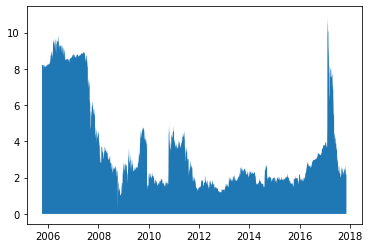

In [10]:
#Plot A specific stock through time to find outliers

plt.fill_between(df.index,df.Low)